In [4]:
from pymatgen.io.ase import AseAtomsAdaptor
from ase.db import connect
import glob
import os
import json
from ase import io
from ase.data import chemical_symbols, atomic_numbers

from pymatgen.core.composition import Composition
from pymatgen.analysis.reaction_calculator import Reaction
from pymatgen.analysis.reaction_calculator import BalancedReaction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# units: eV/V/atom
FARADAYS = 1
# units: K
TEMP = 25 + 273
# units: eV/K/atom
R = 8.63 * (10**-5)
RT = TEMP * R
# units: eV
H2O_gibbs = -2.4577835 
LN_10 = np.log(10)

In [6]:
import pickle
all_oxides = {"NiO": {"formation_energy_per_fu": -2.697,
                            "inv_elements": ["O", "Ni"],
                        },
              "Ni3O4": {"formation_energy_per_fu": -6.953,
                            "inv_elements": ["O", "Ni"],
                        },
              "Ni2O3": {"formation_energy_per_fu": -4.057,
                            "inv_elements": ["O", "Ni"],
                        },
              "NiO2": {"formation_energy_per_fu": -1.343,
                            "inv_elements": ["O", "Ni"],
                        },
              "Ni(OH)2": {"formation_energy_per_fu": -5.040,
                            "inv_elements": ["O", "Ni"],
                        },
              "NiHO2": {"formation_energy_per_fu": -3.470,
                            "inv_elements": ["O", "Ni"],
                        }
             }

In [7]:
#pH, potential = np.mgrid[(pH_range[0][0]):(pH_range[0][1]):pH_range[1], potential_range[0][0]:potential_range[0][1]:potential_range[1]]
pH = 12
pot_start = -0.6
pot_end = 0.8
potential = np.arange(pot_start, pot_end, 0.01)

gibbs_Nihydrox = -5.040
gibbs_NiO = -2.697
gibbs_OHminus = -1.629264 + RT*LN_10*(14-pH)
gibbs_Ni2plus = -0.4999882 + RT*np.log(10**-6)
gibbs_elec = -1*FARADAYS*potential
gibbs_Hplus = -1*RT*LN_10*pH
gibbs_H2O = H2O_gibbs
gibbs_NiOH3minus = -6.0794 + RT*np.log(10**-6) 

In [8]:
# solid Ni + water, #1
cp_Nihydrox1 = gibbs_Nihydrox + 2*gibbs_Hplus + 2*gibbs_elec - 2*gibbs_H2O - 0
cp_NiO1 = gibbs_NiO + 2*gibbs_Hplus + 2*gibbs_elec - 1*gibbs_H2O - 0
# Ni2+ + OH-, #2
cp_Nihydrox2 = gibbs_Nihydrox - 1*gibbs_Ni2plus - 2*gibbs_OHminus
cp_NiO2 = gibbs_NiO + 1*gibbs_Hplus - 1*gibbs_Ni2plus - 1*gibbs_OHminus
# Ni + OH-, #3
cp_Nihydrox3 = gibbs_Nihydrox + 2*gibbs_elec - 1*0 - 2*gibbs_OHminus
cp_NiO3 = gibbs_NiO + 1*gibbs_Hplus + 2*gibbs_elec - 1*0 - 1*gibbs_OHminus
# Ni(OH)3- + H+, # 4
cp_Nihydrox4 = gibbs_Nihydrox + 1*gibbs_H2O - 1*gibbs_NiOH3minus - 1*gibbs_Hplus
cp_NiO4 = gibbs_NiO + 2*gibbs_H2O - 1*gibbs_NiOH3minus - 1*gibbs_Hplus
# Ni2+ for pH = 4.9 and 4
cp_Ni2plus = gibbs_Ni2plus + 2*gibbs_elec
# Ni(OH)3 [-] for pH = 12
cp_NiOH3minus = gibbs_NiOH3minus + 3*gibbs_Hplus + + 2*gibbs_elec - 3*gibbs_H2O - 0
Ni2plus_text = "Ni --> Ni[2+] + 2e[-]"
NiOH3minus_text = "Ni + 3H2O --> Ni(OH)3[-] + 3H[+] + 2e[-]"

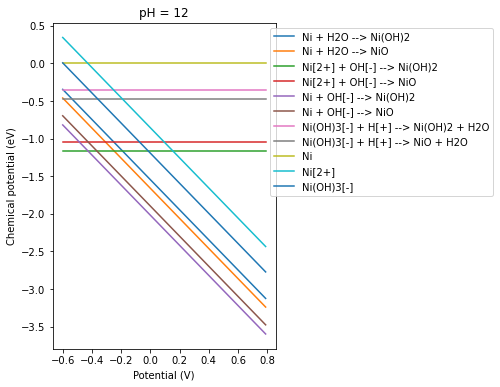

In [9]:
plt.figure(figsize = (4, 6))
plt.plot(potential, cp_Nihydrox1, label = "Ni + H2O --> Ni(OH)2")
plt.plot(potential, cp_NiO1, label = "Ni + H2O --> NiO")
plt.plot(potential, cp_Nihydrox2*np.ones(len(potential)), label = "Ni[2+] + OH[-] --> Ni(OH)2")
plt.plot(potential, cp_NiO2*np.ones(len(potential)), label = "Ni[2+] + OH[-] --> NiO")
plt.plot(potential, cp_Nihydrox3, label = "Ni + OH[-] --> Ni(OH)2")
plt.plot(potential, cp_NiO3, label = "Ni + OH[-] --> NiO")
plt.plot(potential, cp_Nihydrox4*np.ones(len(potential)), label = "Ni(OH)3[-] + H[+] --> Ni(OH)2 + H2O")
plt.plot(potential, cp_NiO4*np.ones(len(potential)), label = "Ni(OH)3[-] + H[+] --> NiO + H2O")
plt.plot(potential, np.zeros(len(potential)), label = "Ni")
plt.plot(potential, cp_Ni2plus, label = "Ni[2+]")
plt.plot(potential, cp_NiOH3minus, label = "Ni(OH)3[-]")

plt.title(("pH = " + str(pH)))
plt.xticks(np.arange(pot_start, pot_end+0.01, 0.2))
plt.ylabel("Chemical potential (eV)")
plt.xlabel("Potential (V)")
plt.legend(loc='upper left', bbox_to_anchor=(0.95, 1))

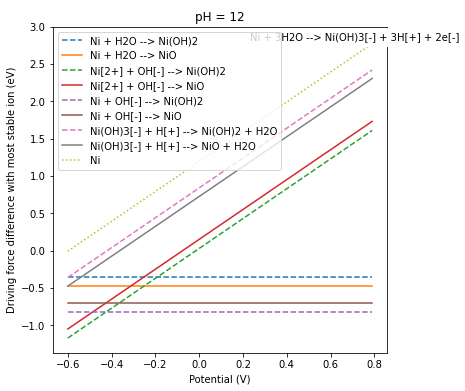

In [13]:
# since theirs is thickness, we could use an absolute value for higher meaning better
# move legend onto plot

plt.figure(figsize = (6, 6))
#ion_sub = cp_Ni2plus
ion_sub = cp_NiOH3minus
txt = NiOH3minus_text
plt.plot(potential, cp_Nihydrox1 - ion_sub, label = "Ni + H2O --> Ni(OH)2", linestyle = "--")
plt.plot(potential, cp_NiO1 - ion_sub, label = "Ni + H2O --> NiO")
plt.plot(potential, (cp_Nihydrox2*np.ones(len(potential))) - ion_sub, label = "Ni[2+] + OH[-] --> Ni(OH)2", linestyle = "--")
plt.plot(potential, (cp_NiO2*np.ones(len(potential))) - ion_sub, label = "Ni[2+] + OH[-] --> NiO")
plt.plot(potential, cp_Nihydrox3 - ion_sub, label = "Ni + OH[-] --> Ni(OH)2", linestyle = "--")
plt.plot(potential, cp_NiO3 - ion_sub, label = "Ni + OH[-] --> NiO")
plt.plot(potential, (cp_Nihydrox4*np.ones(len(potential))) - ion_sub, label = "Ni(OH)3[-] + H[+] --> Ni(OH)2 + H2O", linestyle = "--")
plt.plot(potential, (cp_NiO4*np.ones(len(potential))) - ion_sub, label = "Ni(OH)3[-] + H[+] --> NiO + H2O")
plt.plot(potential, np.zeros(len(potential)) - ion_sub, label = "Ni", linestyle = ":")
plt.annotate(txt, # this is the text
             (0,1), # these are the coordinates to position the label
             xycoords = 'figure fraction',
             textcoords="offset points", # how to position the text
             xytext=(250,-40), # distance from text to points (x,y)
             backgroundcolor="w") # horizontal alignment can be left, right or center
plt.title(("pH = " + str(pH)))
plt.xticks(np.arange(pot_start, pot_end+0.01, 0.2))
plt.ylim(top = 3)
plt.ylabel("Driving force difference with most stable ion (eV)")
plt.xlabel("Potential (V)")
plt.legend(loc='upper left')

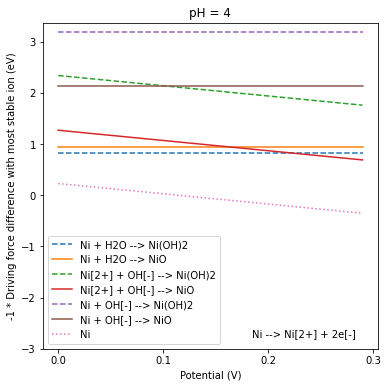

In [106]:
plt.figure(figsize = (6, 6))
#ion_sub = cp_Ni2plus
ion_sub = cp_NiOH3minus
plt.plot(potential, -1*(cp_Nihydrox1 - ion_sub), label = "Ni + H2O --> Ni(OH)2", linestyle = "--")
plt.plot(potential, -1*(cp_NiO1 - ion_sub), label = "Ni + H2O --> NiO")
plt.plot(potential, -1*((cp_Nihydrox2*np.ones(len(potential))) - ion_sub), label = "Ni[2+] + OH[-] --> Ni(OH)2", linestyle = "--")
plt.plot(potential, -1*((cp_NiO2*np.ones(len(potential))) - ion_sub), label = "Ni[2+] + OH[-] --> NiO")
plt.plot(potential, -1*(cp_Nihydrox3 - ion_sub), label = "Ni + OH[-] --> Ni(OH)2", linestyle = "--")
plt.plot(potential, -1*(cp_NiO3 - ion_sub), label = "Ni + OH[-] --> NiO")
plt.plot(potential, -1*(np.zeros(len(potential)) - ion_sub), label = "Ni", linestyle = ":")
plt.annotate(txt, # this is the text
             (1,0), # these are the coordinates to position the label
             xycoords = 'figure fraction',
             textcoords="offset points", # how to position the text
             xytext=(-140,50), # distance from text to points (x,y)
             backgroundcolor="w") # horizontal alignment can be left, right or center
plt.title(("pH = " + str(pH)))
plt.xticks(np.arange(pot_start, pot_end+0.01, 0.1))
plt.ylim(bottom = -3)
plt.ylabel("-1 * Driving force difference with most stable ion (eV)")
plt.xlabel("Potential (V)")
plt.legend(loc='lower left')